# pyGIMLi(empymod)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli
import empymod

## Create model and data

In [2]:
# Offsets
x = np.linspace(1000, 20000, 101)
depth = [0, 1000, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]

freqs = [0.1, 0.3, 1, 3]

mtrue = [2e14, 0.3, 1, 1, 1, 1, 1, 100, 1, 1, 1, 1]
m0 = [2e14, 0.3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Model parameters
inp = {
    'src': [0, 0, 900],
    'rec': [x, np.zeros(x.shape), 1000],
    'depth': depth,
    'freqtime': freqs,
    'verb': 1,
}

data = empymod.dipole(res=mtrue, **inp)
data0 = empymod.dipole(res=m0, **inp)

In [3]:
noise_floor = 1e-17
relative_error = 0.01
mean_noise = 0.0
min_amplitude = noise_floor / 2.0

# Exclude data below noise_floor
cut_data = abs(data) < min_amplitude
data[cut_data] = np.nan + 1j*np.nan
data0[cut_data] = np.nan + 1j*np.nan


# Add random white noise
rng = np.random.default_rng()
std_dev = np.sqrt(noise_floor**2 + np.abs(relative_error*data)**2)
noise = std_dev * ((1+1j)*mean_noise + np.exp(1j * rng.uniform(0, 2*np.pi, data.shape)))
data += noise

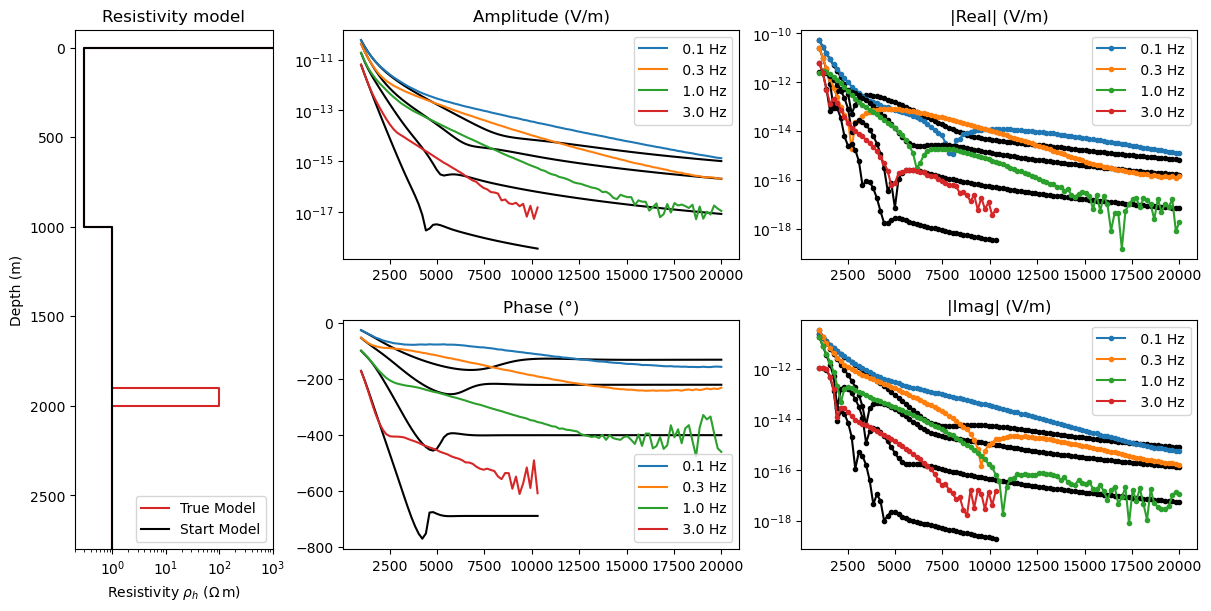

In [4]:
def plot_depth(d, r, d0=-100, dn=+100):    
    return np.repeat(r, 2), np.r_[d[0]+d0, np.repeat(d, 2), d[-1]+dn]

# Create figure
axs = plt.figure(figsize=(12, 6), constrained_layout=True).subplot_mosaic('ABBDD;ACCEE')
ax1, ax2, ax3, ax4, ax5 = axs.values()

# Plot Resistivities
ax1.set_title('Resistivity model')
ax1.plot(*plot_depth(depth, mtrue, dn=500), 'C3', label="True Model")
ax1.plot(*plot_depth(depth, m0, dn=500), 'k', label="Start Model")
ax1.set_xscale('log')
ax1.set_xlim([.2, 1000])
ax1.set_ylim([2800, -100])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel(r'Resistivity $\rho_h\ (\Omega\,\rm{m})$')
ax1.legend()

# Plot Amplitudes
ax2.set_title('Amplitude (V/m)')
for i, f in enumerate(freqs):
    ax2.plot(x, data0[i, :].amp(), 'k')
    ax2.plot(x, data[i, :].amp(), label=f"{f: 2.1f} Hz")
ax2.set_yscale('log')
ax2.legend()

# Plot Phases
ax4.set_title('Phase (°)')
for i, f in enumerate(freqs):
    ax4.plot(x, data0[i, :].pha(deg=True), 'k')
    ax4.plot(x, data[i, :].pha(deg=True), label=f"{f: 2.1f} Hz")
ax4.legend()

# Plot Real
ax3.set_title('|Real| (V/m)')
for i, f in enumerate(freqs):
    ax3.plot(x, abs(data0[i, :].real), 'k.-')
    ax3.plot(x, abs(data[i, :].real), '.-', label=f"{f: 2.1f} Hz")
ax3.set_yscale('log')
ax3.legend()

# Plot Imag
ax5.set_title('|Imag| (V/m)')
for i, f in enumerate(freqs):
    ax5.plot(x, abs(data0[i, :].imag), 'k.-')
    ax5.plot(x, abs(data[i, :].imag), '.-', label=f"{f: 2.1f} Hz")
ax5.set_yscale('log')
ax5.legend();

## Stuff that should move into `empymod.inv.pygimli`

In [5]:
class Forward(pygimli.Modelling):
    
    def __init__(self, inp, routine=None, indices=None):
        """Initialize the model."""
        super().__init__()
        
        self.inp = inp
        self.indices = indices
        
        self.mesh1d = pygimli.meshtools.createMesh1D(len(self.inp['depth'])-1) # free res + 1
        self.setMesh(self.mesh1d)
    
        if routine:
            self.routine = routine
        else:
            self.routine = empymod.bipole
        
    def response(self, x):
        """Forward response."""    
        # TODO: more flexible: anisotropy; thicknesses
        # => mapping function from x to inp
        res = np.r_[2e14, 0.3, x]
        em = self.routine(res=res, **self.inp)

        # Depending if time- or frequency-domain
        if np.iscomplexobj(em):
            em = np.hstack((em.ravel().real, em.ravel().imag))
        else:
            em = em.ravel()

        if self.indices is None:
            return em
        else:
            return em[self.indices]
    
    def createStartModel(self): # What to do with this?
        raise NotImplementedError('THINK ABOUT THIS')

## Inversion

In [6]:
# TODO - IS THIS CORRECT?
dataVals = np.hstack((data.ravel().real, data.ravel().imag))
errorVals = np.hstack([std_dev.ravel(), std_dev.ravel()]) / abs(dataVals)
errorVals[errorVals > 0.5] = 1e8

# Limit to finite
indices = np.isfinite(dataVals)
dataVals = dataVals[indices]
errorVals = errorVals[indices]

In [7]:
%%time
inv = pygimli.Inversion(fop=Forward(inp, empymod.dipole, indices))

# Use log resistivities, but also symlog data!
#inv.dataTrans = pygimli.trans.TransSymLog(1e-20)
#inv.transModel = pygimli.trans.TransLog(0.1) # > 1 Ohmm

model = inv.run(
    dataVals=dataVals,
    relativeError=errorVals,
    startModel=m0[2:],
    verbose=True
)

minv = np.r_[np.nan, np.nan, np.array(model)]

response = np.ones(data.size*2)*np.nan
response[indices] = np.array(inv.response)
response = empymod.EMArray(np.reshape(response[:data.size] + 1j*response[data.size:], data.shape))

12/02/24 - 22:46:42 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 10000/1.00841e+14
fop: <__main__.Forward object at 0x7fe8d42299a0>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7fe8d41dd6a0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7fe8d42299f0>
min/max (data): -3.2e-11/5.2e-11
min/max (error): 0.99%/1.0e+10%
min/max (start model): 1/1
--------------------------------------------------------------------------------
min/max(dweight) = 10000/1.00841e+14
Building constraints matrix
constraint matrix of size(nBounds x nModel) 9 x 10
check Jacobian: wrong dimensions: (0x0) should be (706x10)  force: 1
jacobian size invalid, forced recalc: 1
inv.iter 0 ... chi² = 2252.70calculating jacobian matrix (forced=1)...Create Jacobian matrix (brute force) ... ... 1.69031 s.
... 1.8601 s
min data = -3.22986e-11 max data = 5.22877e-11 (706)
min error = 0.00991656 max error = 1e+08 (706)
min response = -3.29052e-11 max response = 5.24701e-11 (706)
calc without reference model
0: rms/rrms(data, response) = 1.47556e-

## Plot result

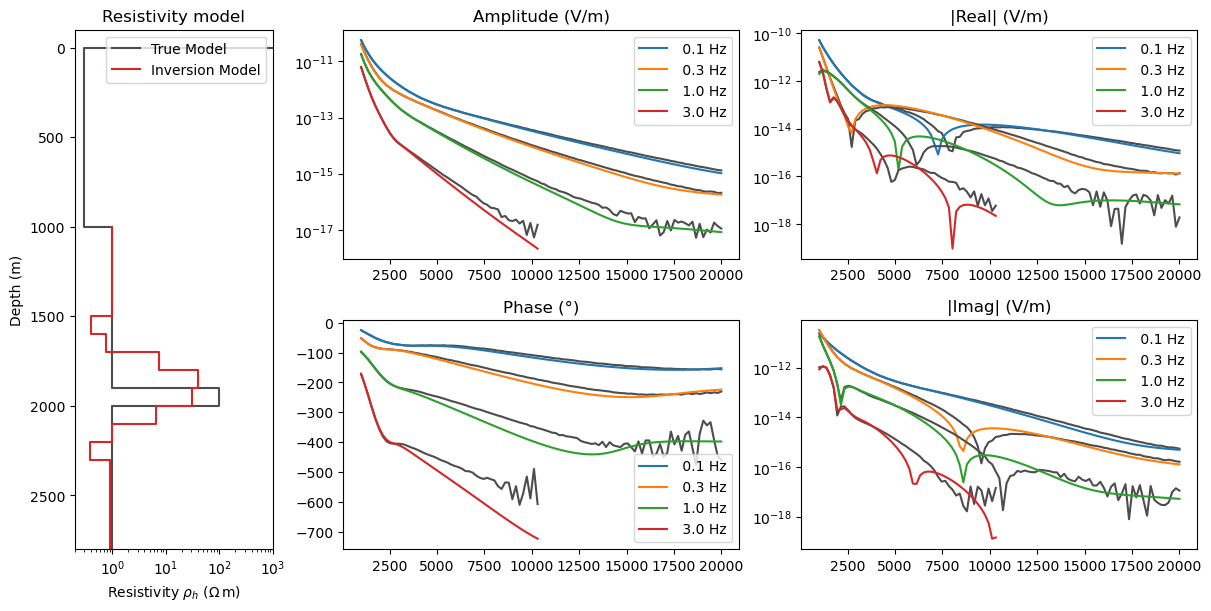

In [8]:
# Create figure
axs = plt.figure(figsize=(12, 6), constrained_layout=True).subplot_mosaic('ABBDD;ACCEE')
ax1, ax2, ax3, ax4, ax5 = axs.values()

# Plot Resistivities
ax1.set_title('Resistivity model')
#ax1.plot(*plot_depth(depth, m0, dn=500), 'k', label="Start Model")
ax1.plot(*plot_depth(depth, mtrue, dn=500), '.3', label="True Model")
ax1.plot(*plot_depth(depth, minv, dn=500), 'C3', label="Inversion Model")
ax1.set_xscale('log')
ax1.set_xlim([.2, 1000])
ax1.set_ylim([2800, -100])
ax1.set_ylabel('Depth (m)')
ax1.set_xlabel(r'Resistivity $\rho_h\ (\Omega\,\rm{m})$')
ax1.legend()

# Plot Amplitudes
ax2.set_title('Amplitude (V/m)')
for i, f in enumerate(freqs):
    #ax2.plot(x, data0[i, :].amp(), 'k')
    ax2.plot(x, data[i, :].amp(), '.3')
    ax2.plot(x, response[i, :].amp(), label=f"{f: 2.1f} Hz")
ax2.set_yscale('log')
ax2.legend()

# Plot Phases
ax4.set_title('Phase (°)')
for i, f in enumerate(freqs):
    #ax4.plot(x, data0[i, :].pha(deg=True), 'k')
    ax4.plot(x, data[i, :].pha(deg=True), '.3')
    ax4.plot(x, response[i, :].pha(deg=True), label=f"{f: 2.1f} Hz")
ax4.legend()

# Plot Real
ax3.set_title('|Real| (V/m)')
for i, f in enumerate(freqs):
    #ax3.plot(x, abs(data0[i, :].real), 'k')
    ax3.plot(x, abs(data[i, :].real), '.3')
    ax3.plot(x, abs(response[i, :].real), label=f"{f: 2.1f} Hz")
ax3.set_yscale('log')
ax3.legend()

# Plot Imag
ax5.set_title('|Imag| (V/m)')
for i, f in enumerate(freqs):
    #ax5.plot(x, abs(data0[i, :].imag), 'k')
    ax5.plot(x, abs(data[i, :].imag), '.3')
    ax5.plot(x, abs(response[i, :].imag), label=f"{f: 2.1f} Hz")
ax5.set_yscale('log')
ax5.legend();

In [9]:
empymod.Report(['pyGIMLi', 'pgcore'])

--------------------------------------------------------------------------------
  Date: Mon Feb 12 22:46:53 2024 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.8.18 | packaged by conda-forge | (default, Oct 10 2023, 15:44:36)
  [GCC 12.3.0]

           pyGIMLi : 1.4.5
            pgcore : 1.4.0
             numpy : 1.23.5
             scipy : 1.10.1
             numba : 0.58.1
           empymod : 2.2.2
           IPython : 8.12.2
        matplotlib : 3.7.3
--------------------------------------------------------------------------------